# LSTM(Long-Short Term Memory)
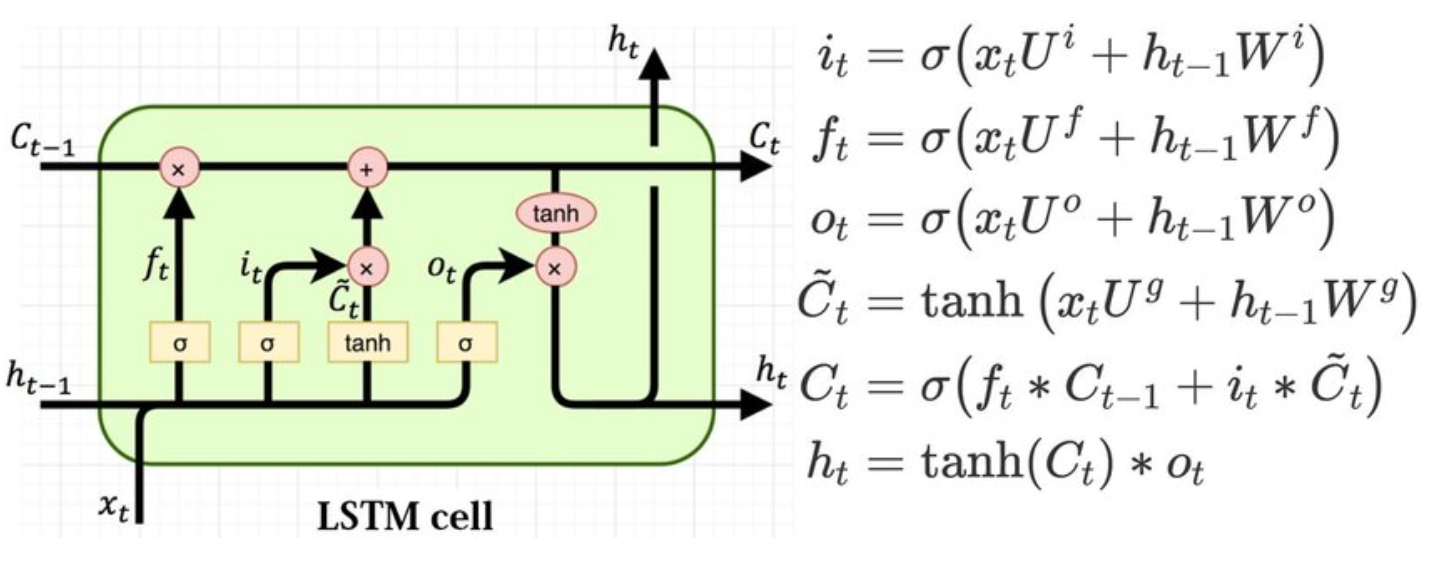

## 순전파(Forward Propagation)

1. 망각 게이트(forget gate)

과거의 정보를 어느정도 기억할지 결정한다. 

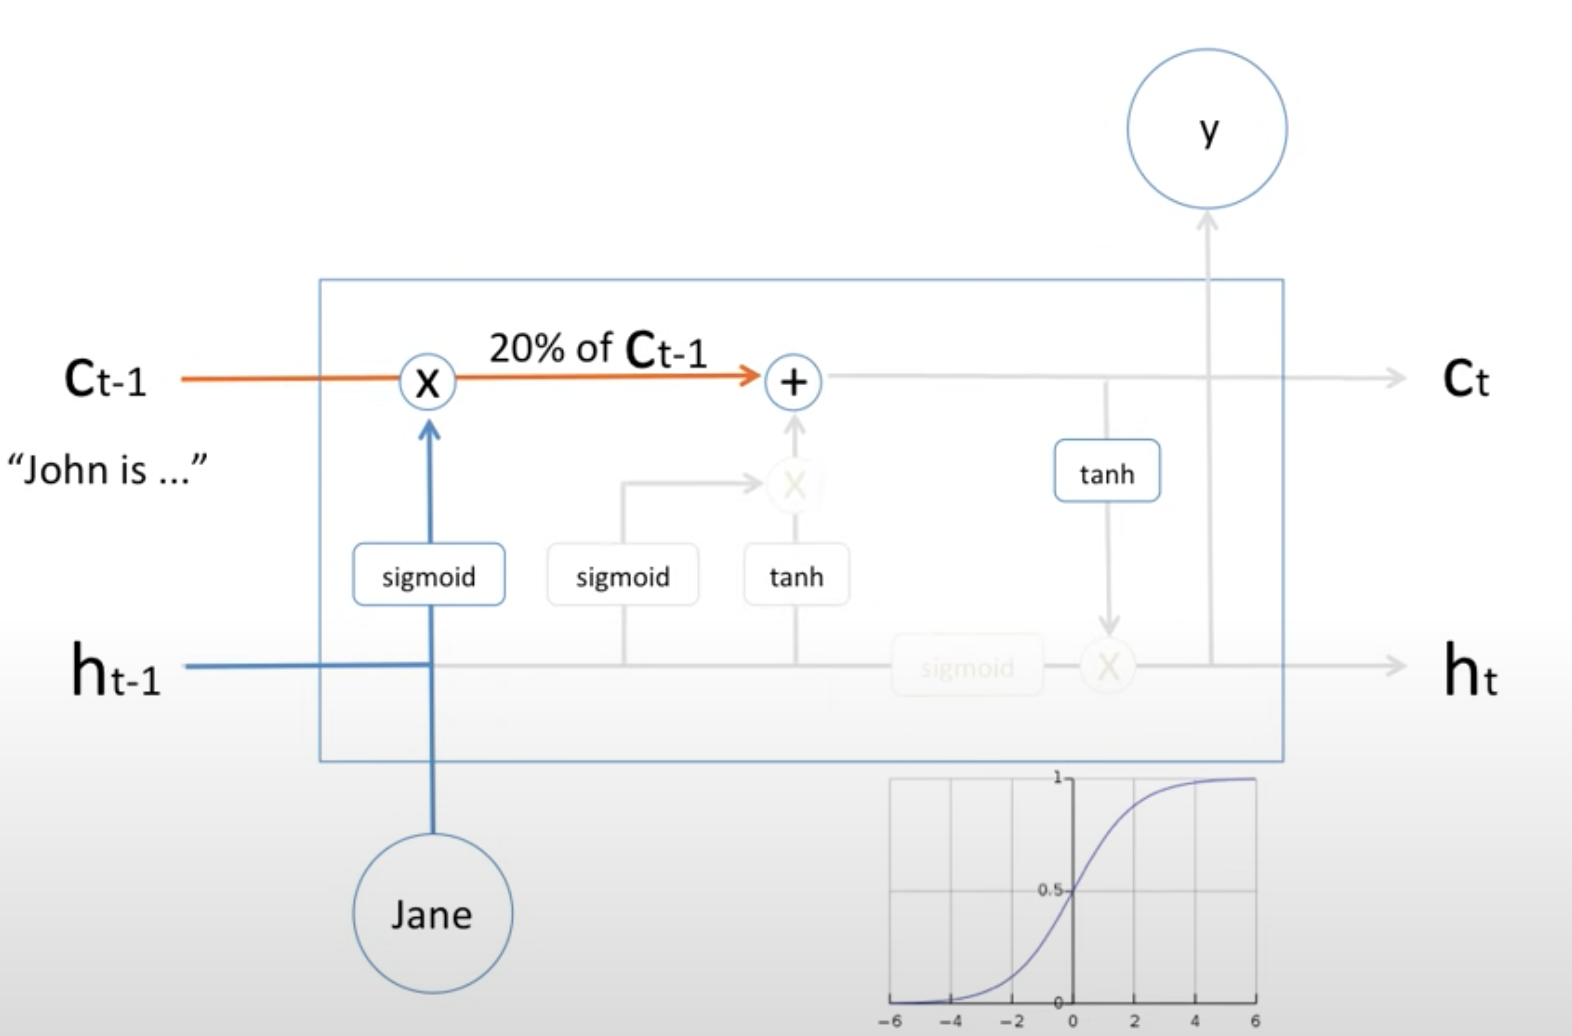


2. 입력 게이트(input gate)

현재 정보를 기억하기 위해 만들어졌다. 현재 메모리에 새로운 정보를 반영할 지 결정하는 역할을 한다. 계산값이 1이면 입력 Xt가 들어올 수 있도록 허용하고, 0이면 차단한다.

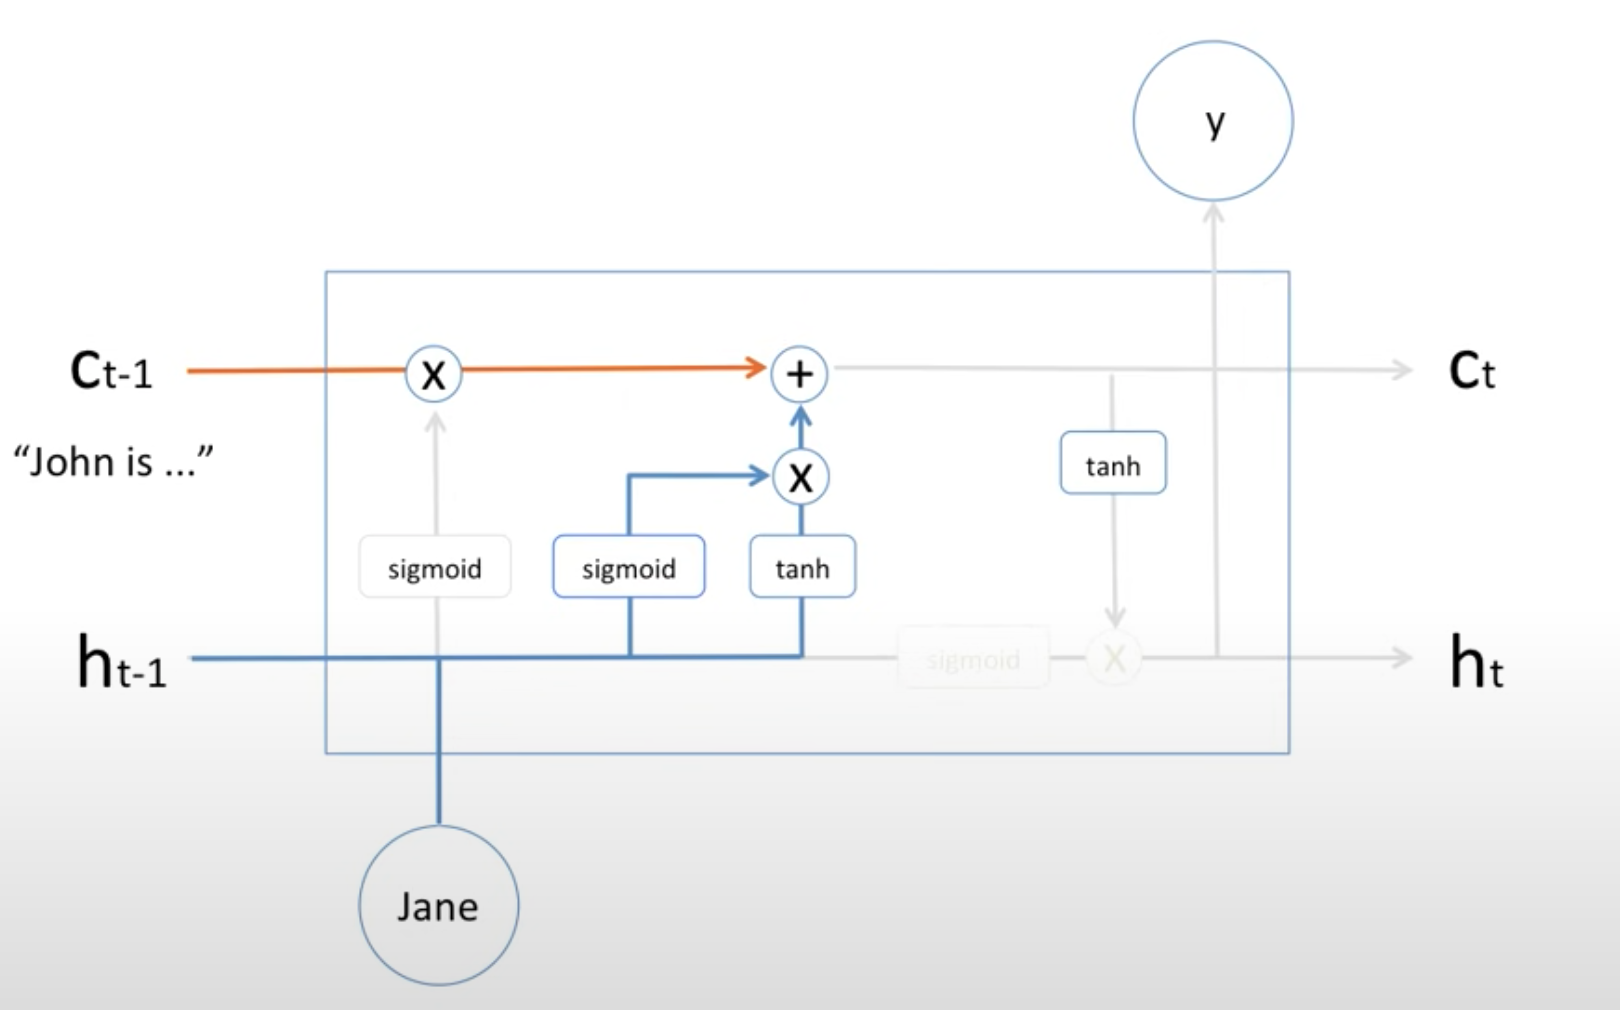

3. 셀(cell)

각 단계에 대한 은닉 노드(hidden node)를 메모리 셀이라고 한다. ‘총합’을 사용하여 셀 값을 반영하며, 이를 통해 기울기 소멸 문제를 해결한다. 망각 게이트와 입력 게이트의 이전 단계 셀 정보를 계산하여 현재 단계의 셀 상태(cell state)를 업데이트 한다.

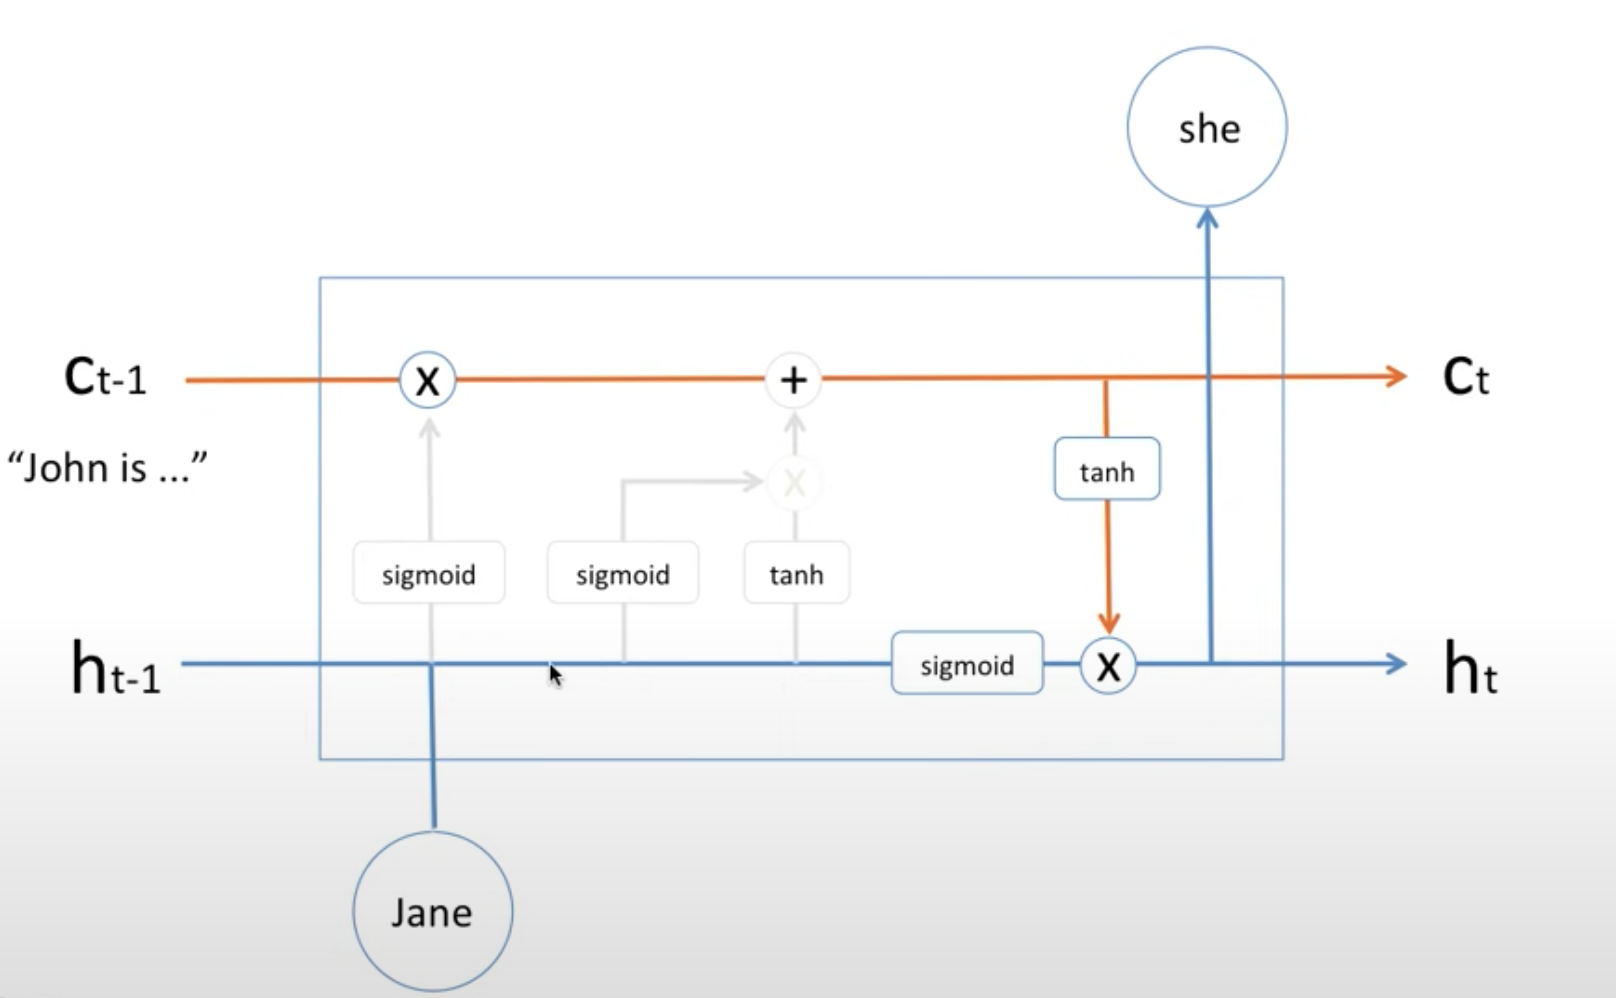

## 역전파(Back Propagation)

LSTM은 셀을 통해 역전파를 수행하므로 중단 없는 기울기(uninterrupted gradient flow)라고도 한다. 최종 오차는 모든 노드에 전파되는데, 이 때 셀을 통해 중단 없이 전파된다.


#### Refer
- https://www.youtube.com/watch?v=bX6GLbpw-A4
- https://velog.io/@choonsik_mom/pytorch%EB%A1%9C-LSTM-%EA%B5%AC%ED%98%84%ED%95%98%EA%B8%B0

## Implementation

### LSTMCell

In [15]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias = True):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.x2h = nn.Linear(input_size, 4* hidden_size, bias = bias)
        self.h2h = nn.Linear(hidden_size, 4* hidden_size, bias = bias)
        self.reset_parameters()
        
    def reset_parameters(self):
        """ 딥러닝 모델의 가중치를 초기화하는 함수 """
        std = 1.0 / math.sqrt(self.hidden_size)
        
        for w in self.parameters: # 가중치에 대한 파라미터를 반환하고, 두 번째 호출에서는 편향에 대한 파라미터를 반환
            w.data.uniform_(-std, std) # uniform 분포에서 랜덤하게 값을 추출하여 초기화합니다. 추출된 값은 -std부터 std까지의 균일 분포를 따릅니다.
    def forward(self, x , hidden):
        # x는 새로운 입력값
        hx , cx = hidden # 이전 타임 스텝에서의 은닉 상태(hx)와 셀 상태(cx)를 가져온다
        x = x.view(-1, x.size(1)) # 1차원 변경
        gates = self.x2h(x) + self.h2h(hx) # 입력 x에 대한 가중치와 이전 타임 스텝의 은닉 상태 (hx)에 대한 가중치를 각각 계산
        # 이 부분이 역전파 과정에서 기울기 소실 문제를 어느 정도 극복할 수 있게 하는 부분
        gates = gates.squeeze() # 요소가 1인 것만 제거

        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1) # 4등분으로 나눈다.
        
        ingate = F.sigmoid(ingate) # 입력 게이트에 시그모이드 적용
        forgetgate = F.sigmoid(forgetgate) # 망각 게이트에 시그모이드 적용
        cellgate = F.tanh(cellgate) # 셀 게이트에 탄젠트 적용
        outgate = F.sigmoid(outgate) # 출력 게이트에 시그모이드 적용
        
        cy = torch.mul(cx, forgetgate) + torch.mul(ingate, cellgate)
        hy = torch.mul(outgate, F.tanh(cy))
        return (hy, cy)

### LSTMModel

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, bias= True):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = LSTMCell(input_dim, hidden_dim, layer_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):

        # 0 텐서를 만들며 (lstm층 수 , batch size, hidden size) 의 형태로 만들어지게 된다.
       if torch.cuda.is_available() :
           h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
       else :
           h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
           
       if torch.cuda.is_available() :
           c0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
       else :
           c0 = Variable(torch.zeros(self.layer_dim, x.size(0), hidden_dim))
           
       outs = []
       cn =  c0[0,:,:] # 그냥 하드 코딩일 뿐이다. 0번째 lstm층을 초기화하여 사용한다는 뜻
       hn = h0[0,:,:]
       
       for seq in range(x.size(1)) :
           hn, cn = self.lstm(x[:, seq, :], (hn, cn))
           outs.append(hn)
           
       out = outs[-1].squeeze() #가장 마지막의 은닉 상태를 가져와서 텐서의 차원을 줄인다. 즉 1차원으로 변경
       out = self.fc(out)
       return out

# torch 공부

In [6]:
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MyModel, self).__init__()
        self.fc = nn.Linear(input_size, hidden_size)

    def forward(self, x):
        return self.fc(x)

# 모델 생성
model = MyModel(input_size=10, hidden_size=5)

# 모델 내의 파라미터 출력
std = 1.0 / math.sqrt(5)
for parameter in model.parameters():
    print(parameter.data)
    parameter.data.uniform_(-std, std)
    print(parameter.data)
    print()

tensor([[-0.0091, -0.2558,  0.1724, -0.1244,  0.0174, -0.0653,  0.2903,  0.1260,
         -0.1977,  0.1332],
        [-0.1514,  0.1835, -0.2147,  0.2684,  0.0163,  0.0924, -0.0557, -0.0595,
         -0.1466,  0.2419],
        [-0.2530, -0.1621, -0.0401,  0.1076, -0.1350, -0.2072, -0.2437,  0.1423,
         -0.0974, -0.0614],
        [-0.0613, -0.2148, -0.1256,  0.2918,  0.2486, -0.2157, -0.0923, -0.0643,
         -0.1875, -0.0266],
        [-0.1877, -0.1979, -0.3136,  0.1142,  0.2255,  0.2311,  0.0898, -0.1731,
         -0.3001, -0.1135]])
tensor([[ 0.2143, -0.4078,  0.0918, -0.3910,  0.3613,  0.2601,  0.3454,  0.2145,
          0.2961, -0.3472],
        [ 0.0283, -0.0405,  0.4158, -0.3880,  0.1992, -0.1764, -0.3248, -0.2981,
         -0.3153,  0.4383],
        [ 0.0853,  0.0839,  0.2990, -0.2769,  0.3664,  0.1118,  0.1988, -0.1430,
         -0.2453, -0.1127],
        [ 0.3111,  0.2657,  0.1452, -0.3237, -0.1068, -0.4378, -0.4077, -0.4449,
         -0.1940,  0.4391],
        [-0.2066, 

In [11]:
import torch
# 차원이 1인 것을 삭제한다!!
# 크기가 1인 차원이 있는 텐서 생성
tensor = torch.randn(1, 3, 1, 1,1,1,1,14)  # shape: (1, 3, 1, 4)

# squeeze 적용
squeezed_tensor = tensor.squeeze()

# 결과 출력
print("Original Tensor:", tensor.shape)
print("Squeezed Tensor:", squeezed_tensor.shape)


Original Tensor: torch.Size([1, 3, 1, 1, 1, 1, 1, 14])
Squeezed Tensor: torch.Size([3, 14])


In [20]:
import torch

layer_dim = 2
batch_size = 3
hidden_dim = 4

# 초기 은닉 상태 생성
h0 = torch.zeros(layer_dim, batch_size, hidden_dim)

print(h0)
h0.shape

tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]])


torch.Size([2, 3, 4])

In [21]:
h0[0,:,:]

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

In [25]:
ass = torch.tensor([[[1, 2, 3]]])

In [26]:
ass.squeeze()

tensor([1, 2, 3])